# Quick Analysis of COVID-19 confirmed cases data

I've been quite frustrated with the data showing raw cases.  I'm much more interested in how many cases there are compared with the total population of a country or region.  The following adjusts the latest confirmed cases data to adjust for the total population of the country or region.  All numbers are percentages, and as you can tell, they are quite small at the moment.  But it's helpful for comparisons.

Data was sourced from: https://github.com/CSSEGISandData/COVID-19

Last Updated: 2020-03-29

In [1]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dateparser
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
pop_filename='./general_data/world-pop.csv'
pop = pd.read_csv(pop_filename)
pop['region'] = pop['region'].fillna('')
pop['population'] = pop['population'].apply(float)
pop = pop.set_index(['country', 'region'])

In [3]:
filename='./output.csv'
df = pd.read_csv(filename, skiprows=0)
df = df.drop(columns=['Deaths', 'Recovered'])

df['region'] = df['region'].fillna('')
df = df.set_index(['country', 'region'])#, 'date'])
df['date'] = df['date'].apply(pd.to_datetime)
df = pd.merge(df, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
df['ratio'] = df['Confirmed']/df['population'] * 1000000.0
df = df.fillna(0)
df['Confirmed'] = df['Confirmed'].apply(int)
df = df.reset_index()
def by_country(df, names):
    df = df.loc[names]
    df = df.fillna(0)
    for d in df.columns:
        if d in ['country', 'population']:
            continue
        p = df['population'].apply(float)
        v = df[d]
        v = v.apply(float)
        v = v.divide(p)*100.0
        df[d] = v
    df = df.transpose()
    return df


# Latest Number of Confirmed Cases

In [4]:
areas_of_interest = [('US', 'Texas'), ('US', 'Utah'), ('Canada', 'British Columbia'), ('Canada','Ontario')]
pd.pivot_table(df, values='Confirmed', index=['date'],
                    columns=['country', 'region'], aggfunc=np.sum)[areas_of_interest].tail()

country         US                  Canada        
region       Texas   Utah British Columbia Ontario
date                                              
2020-03-25  1229.0  340.0            617.0   688.0
2020-03-26  1563.0  396.0            725.0   858.0
2020-03-27  1937.0  472.0            725.0   994.0
2020-03-28  2455.0  602.0            884.0  1144.0
2020-03-29  2792.0  720.0            884.0  1355.0

# Canadian Provinces - Percentage of population confirmed

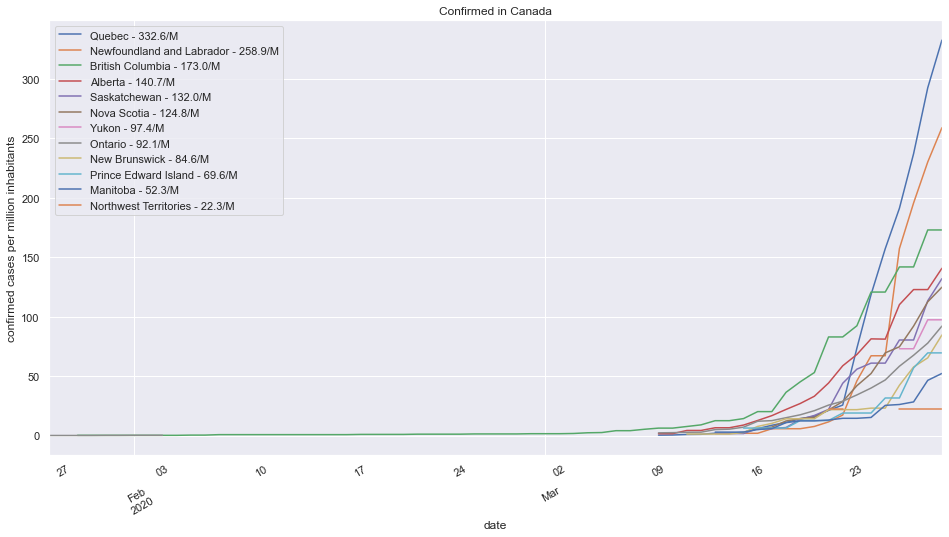

In [5]:
canada = df.loc[df['country'] == 'Canada']
canada = canada.drop(columns=['country'])

canada = canada.set_index(['date', 'region'])['ratio'].unstack(level=-1)
last_date = max(canada.index).date()
x = pd.DataFrame(canada.loc[last_date].fillna(0).sort_values(ascending=False))
canada = canada[x.index]

labels = list(map(lambda x: "%s - %.1f/M" % x, zip(x.index, x[x.columns[0]].to_list())))

ax = canada.plot(rot=30, figsize=(16,8), title='Confirmed in Canada')
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
ax.legend(labels)
pass

In [6]:
canada.tail()

region,Quebec,Newfoundland and Labrador,British Columbia,Alberta,Saskatchewan,Nova Scotia,Yukon,Ontario,New Brunswick,Prince Edward Island,Manitoba,Northwest Territories
date,,,,,,,,,,,,
2020-03-25,157.185669,67.131472,120.721976,81.121268,60.930923,69.568278,NaN,46.765096,23.077130,31.613956,25.408035,NaN
2020-03-26,191.152766,157.279449,141.853213,110.125520,80.394968,74.683592,73.031793,58.320425,42.308072,31.613956,26.133979,22.269731
2020-03-27,237.066911,195.640290,141.853213,122.814881,80.394968,92.075662,73.031793,67.564688,57.692825,56.905120,28.311810,22.269731
2020-03-28,292.585545,230.165048,172.963091,122.814881,113.399218,112.536920,97.375724,77.760566,65.385202,69.550702,46.460407,22.269731
2020-03-29,332.643294,258.935678,172.963091,140.715943,132.017000,124.813675,97.375724,92.102769,84.616144,69.550702,52.267957,22.269731


# US States - Percentage of population confirmed

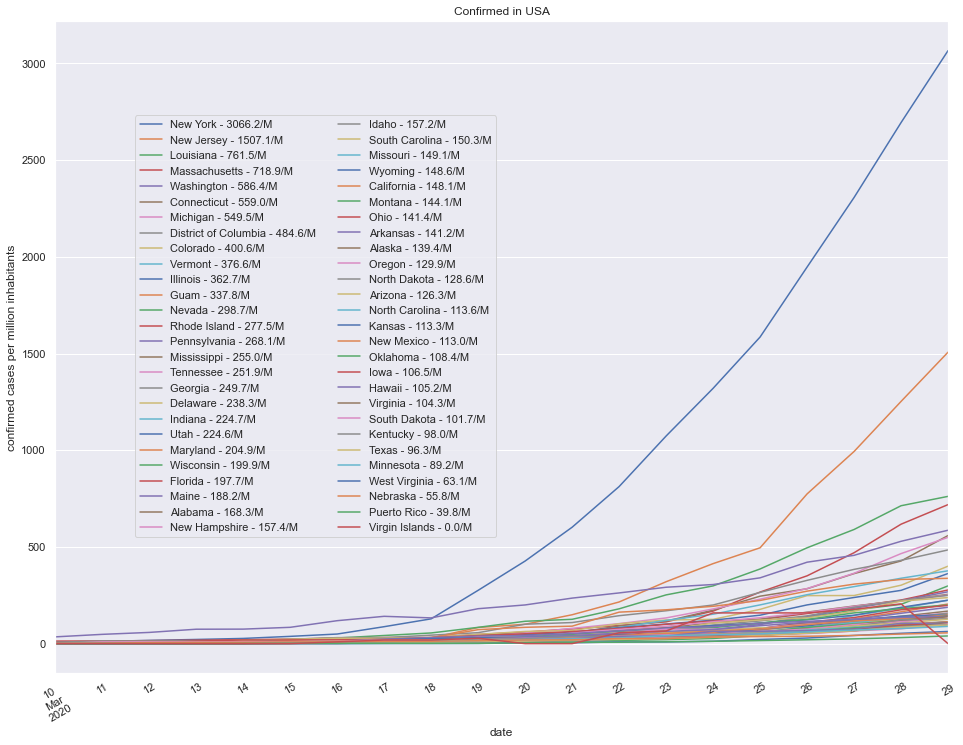

In [7]:
usa = df.loc[df['country'] == 'US'].loc[df['region'] != ''].groupby(by=['country', 'region', 'date']).sum()
last_date = str(max(usa.index.get_level_values(2)).date())
last_date
idx = pd.IndexSlice

x = usa.loc[idx[:,:,[last_date]], idx[['ratio', 'Confirmed', 'population']]].sort_values(by=['ratio'], ascending=False)
labels = list(map(lambda x: "%s - %.1f/M" % (x[0][1], x[1]), zip(x.index, x[x.columns[0]].to_list())))
rows = list(filter(lambda x: str(x[2]) > '2020-03-07', usa.index))
usa = usa.loc[rows]
usa = usa.reset_index()
usa = usa.drop(columns=['country'])

usa = pd.pivot_table(usa, values='ratio', index=['date'],
                     columns=['region'], aggfunc=np.sum).fillna(0)[x.index.get_level_values(1)]

ax = usa.plot(rot=30, figsize=(16,12), title='Confirmed in USA')
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
ax.legend(labels, bbox_to_anchor=(0.5, 0.2), ncol=2)
pass

# Percentage of Population Confirmed - Top 12 US States

In [8]:
x[:12][['Confirmed', 'ratio']]

Confirmed        ratio
country region               date                              
US      New York             2020-03-29      59648  3066.173849
        New Jersey           2020-03-29      13386  1507.060759
        Louisiana            2020-03-29       3540   761.487818
        Massachusetts        2020-03-29       4955   718.897039
        Washington           2020-03-29       4465   586.350984
        Connecticut          2020-03-29       1993   559.001281
        Michigan             2020-03-29       5488   549.522237
        District of Columbia 2020-03-29        342   484.591547
        Colorado             2020-03-29       2307   400.608745
        Vermont              2020-03-29        235   376.609203
        Illinois             2020-03-29       4596   362.694517
        Guam                 2020-03-29         56   337.821534

# Top Countries Confirmed by Percentage of Population


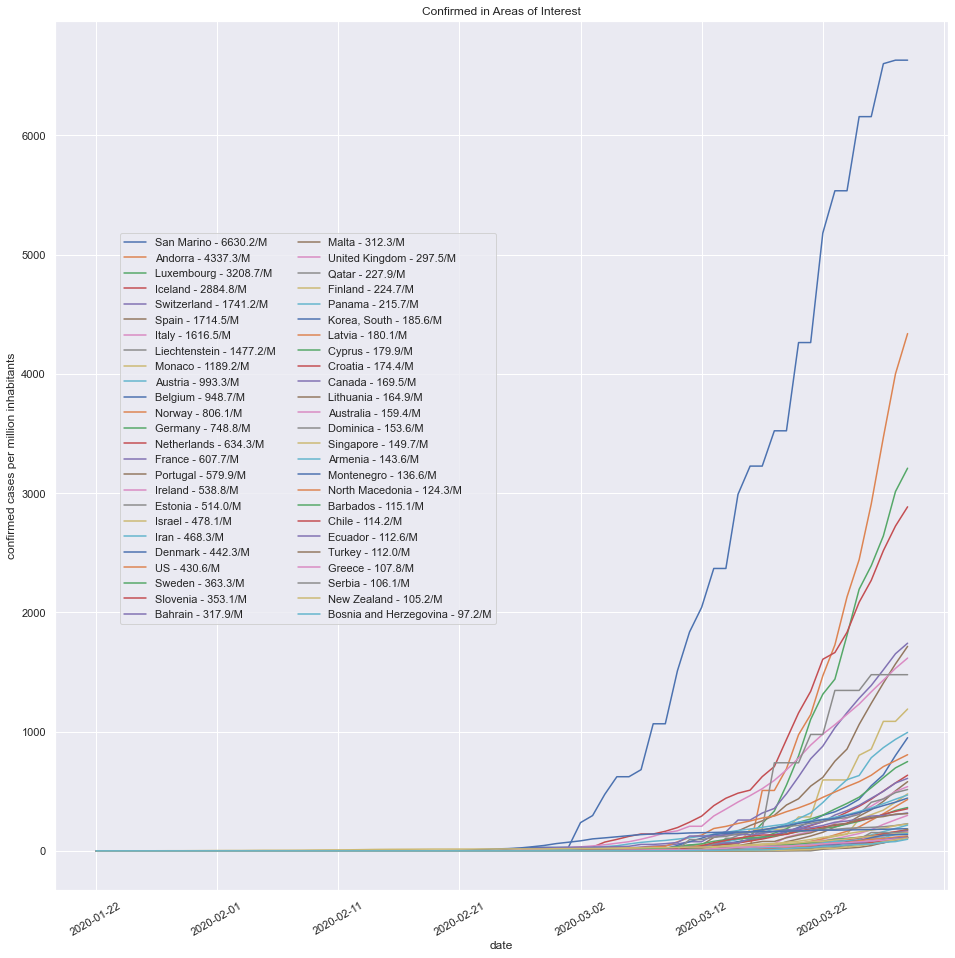

In [9]:
filename = "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
world = pd.read_csv(filename, skiprows=0)
world = world.drop(columns=['Lat', 'Long']).rename(columns={"Province/State": "region", "Country/Region": "country"})
world['region'] = world['region'].fillna("")
world = world.groupby(by=['country']).sum()
world['region'] = ""

world = pd.merge(world, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
world = world.drop(columns=['region'])
# rename columns
columns = dict([(d, str(dateparser.parse(d).date())) for d in world.columns if d not in ['population']])
world = world.rename(columns=columns)

world_pop = world.copy()

for d in world.columns:
    if d in ['country', 'population']:
        continue
    p = world['population']
    dd = str(dateparser.parse(d).date())
    world_pop[dd] = world[d].divide(p)*1000000.0
world = world.drop(columns=['population'])
world_pop = world_pop.drop(columns=['population'])
last_date = max(world_pop.columns)
world_pop = world_pop.sort_values(by=[last_date], ascending=False)
last = world_pop[last_date]

world_pop = world_pop.transpose()

countries = last[:50]
labels = list(map(lambda x: "%s - %.1f/M" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass


# Comparison of areas of interest - Percent of Population confirmed

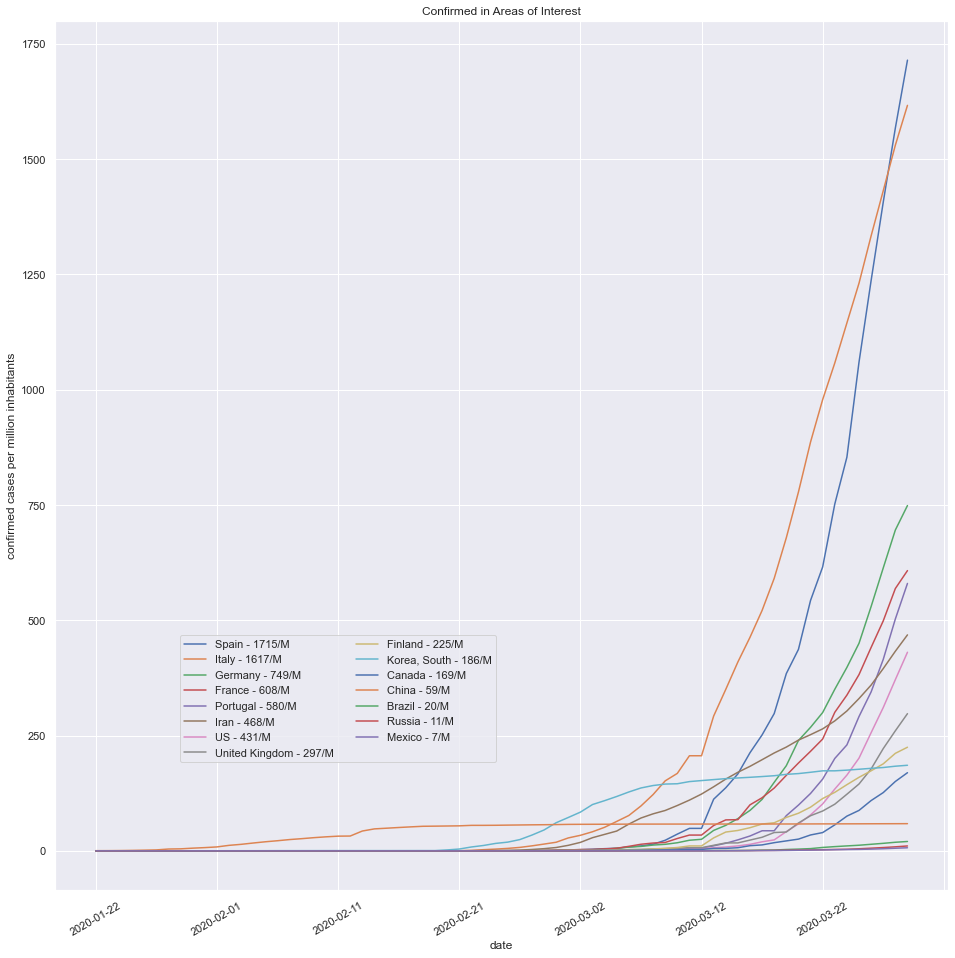

In [10]:
areas_of_interest = ['US', 'Canada', 'Iran', 'China', 'Korea, South', 'Italy', 'Spain',
                    'Germany', 'France', 'United Kingdom', 'Russia', 'Finland', 'Portugal',
                    'Brazil', 'Mexico']

areas = list(filter(lambda x: x in areas_of_interest, last.index))

countries = last[areas]
labels = list(map(lambda x: "%s - %.f/M" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass

In [11]:
world_pop[countries.index].tail(6)

country,Spain,Italy,Germany,France,Portugal,Iran,US,United Kingdom,Finland,"Korea, South",Canada,China,Brazil,Russia,Mexico
2020-03-24,853.634412,1144.705136,397.767112,337.706086,229.727162,303.311961,164.258402,122.787245,143.528964,175.016078,75.285648,58.583501,10.727107,3.426126,2.908295
2020-03-25,1059.739449,1230.918761,450.065540,382.162311,291.292485,330.280087,201.053018,144.986408,159.476627,176.952739,87.725320,58.633762,12.192716,4.554325,3.209426
2020-03-26,1236.758634,1333.564273,529.833607,441.143690,344.688002,359.485370,256.247998,177.653470,173.612055,178.966867,109.069746,58.720642,14.250296,5.814032,3.764142
2020-03-27,1406.543811,1431.344756,613.436328,498.632247,415.103948,395.255424,310.718578,221.766036,188.653600,180.729229,126.339572,58.803214,16.312650,7.170639,4.635838
2020-03-28,1567.404191,1530.200840,695.724656,568.839644,502.832102,432.859212,371.302237,260.373932,211.487754,183.556754,150.463360,58.876451,18.637573,8.748734,5.681873
2020-03-29,1714.545637,1616.530299,748.782780,607.697788,579.861701,468.323643,430.623544,297.492859,224.717065,185.590249,169.460169,58.964767,20.318010,10.617530,6.719983


# Select US States and Canadian Provinces
## Percentage of population confirmed

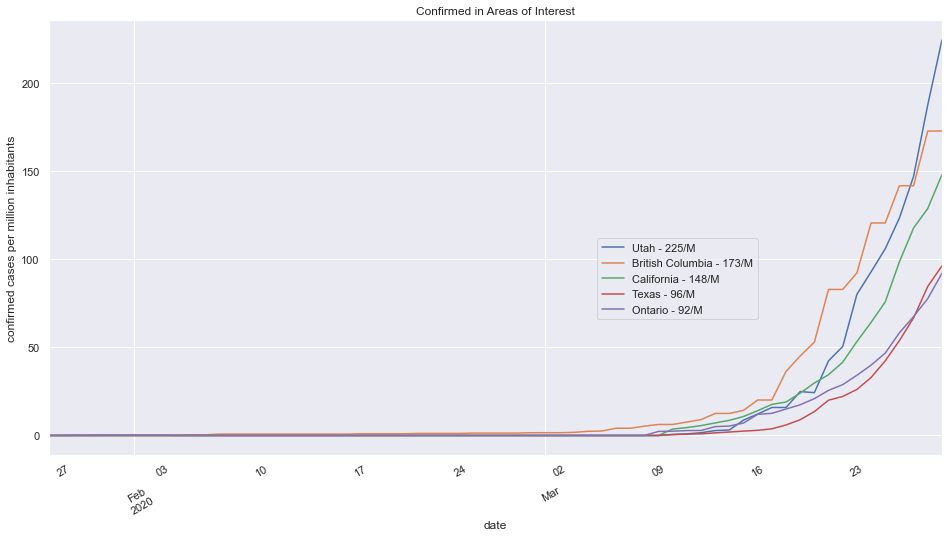

In [12]:
interest = [('US', 'Texas'), ('US', 'Utah'), ('US', 'California'), ('Canada', 'British Columbia'), ('Canada', 'Ontario')]

def f(x):
    if x[0:2] not in interest:
        return False
    
    return True

usa_areas = list(filter(f, usa.columns))
canada_areas = list(filter(f, canada.columns))

u = usa[['Texas', 'Utah', 'California']]
c = canada[['Ontario', 'British Columbia']]

of_interest = pd.DataFrame()
for column in c.columns:
    of_interest[column] = c[column]
for column in u.columns:
    of_interest[column] = u[column]
of_interest = of_interest.fillna(0)

last_date = max(of_interest.index)
last = of_interest.loc[last_date].sort_values(ascending=False).fillna(0)

labels = ["%s - %.f/M" % v for v in zip(last.index, last.values)]
ax = of_interest[last.index].plot(rot=30, figsize=(16,8), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.8, 0.3))
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass